# Configuração do ambiente

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from typing import Dict
from time import time
from sys import maxsize as inf

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Obtenção dos Dados

In [273]:
size = 10
# Dados de entrada sobre as frutas para a geração dos dados aleatórios.
inputs = [{'Class':     'Banana', 'Mean_height': 18, 'Std_height':   3, 'Mean_width':  5, 'Std_width':   1},
          {'Class':      'Apple', 'Mean_height': 10, 'Std_height': 1.5, 'Mean_width': 12, 'Std_width': 1.5},
          {'Class':      'Lemon', 'Mean_height':  5, 'Std_height':   1, 'Mean_width':  5, 'Std_width':   1},
          {'Class': 'Watermelon', 'Mean_height': 20, 'Std_height': 2.5, 'Mean_width': 25, 'Std_width':   3},
          {'Class':     'Papaya', 'Mean_height': 28, 'Std_height':   3, 'Mean_width': 15, 'Std_width':   2},
          {'Class':      'Mango', 'Mean_height': 17, 'Std_height': 1.5, 'Mean_width': 12, 'Std_width': 1.5},
          {'Class': 'Strawberry', 'Mean_height':  4, 'Std_height': 0.5, 'Mean_width':  2, 'Std_width': 0.5},
          {'Class':      'Grape', 'Mean_height':  2, 'Std_height': 0.5, 'Mean_width':  2, 'Std_width': 0.5}]

heights = np.array([])
widths = np.array([])
classes = []
# Para cada entrada, acessa a média e o desvio padrão da altura e largura de cada
# fruta e gera uma amostra com base da distribuição normal desses dados.
for input_i in inputs:
  loc_h   = input_i['Mean_height']
  scale_h = input_i['Std_height']
  height = np.random.normal(loc=loc_h, scale=scale_h, size=size)
  heights = np.concatenate([heights, height])

  loc_w   = input_i['Mean_width']
  scale_w = input_i['Std_width']
  width  = np.random.normal(loc=loc_w, scale=scale_w, size=size)
  widths = np.concatenate([widths, width])

  class_i = {
      'Banana': 0,
      'Apple': 1,
      'Lemon': 2,
      'Watermelon': 3,
      'Papaya': 4,
      'Mango': 5,
      'Strawberry': 6,
      'Grape': 7
  }[input_i['Class']]

  classes += [class_i] * size

classes = np.array(classes)

# Junta os dois arrays e transpôe
data = np.vstack((heights, widths)).T
data

array([[15.96292882,  7.54711479],
       [18.34849465,  5.37853428],
       [22.10415047,  5.62700496],
       [17.72725747,  5.60570014],
       [16.9231911 ,  5.52845778],
       [15.74703489,  4.54209499],
       [23.97471754,  7.42498452],
       [23.51416707,  6.53520769],
       [19.17689468,  6.1575079 ],
       [15.558029  ,  6.4151007 ],
       [ 6.61316801, 11.05637598],
       [10.49060088, 11.71938877],
       [ 9.12097828, 11.73439948],
       [10.73606558, 12.55556178],
       [12.57934685, 12.30597169],
       [10.65916816, 11.82736718],
       [ 8.4366765 , 11.43438823],
       [ 8.24670504, 14.92193047],
       [10.18283258, 12.72179616],
       [ 8.18772431, 10.95673699],
       [ 5.64294079,  5.13056576],
       [ 5.17106368,  5.40833071],
       [ 5.4360707 ,  7.21124641],
       [ 5.78907007,  5.39056635],
       [ 3.39149716,  5.24143825],
       [ 6.07772827,  4.86805975],
       [ 4.15270799,  3.39415219],
       [ 5.68932848,  4.23119478],
       [ 3.28152996,

# Teste com SKlearn

In [183]:
st = time()

X = data
y = classes

# Dividir o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar o classificador de árvore de decisão
clf = DecisionTreeClassifier()

# Treinar o classificador com os dados de treinamento
clf.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = clf.predict(X_test)

# Calcular a precisão das previsões
accuracy = accuracy_score(y_test, y_pred)

print(f'A precisão do classificador de árvore de decisão é: {accuracy}')

print(f'Tempo de execução: {time()-st} Segundos')

A precisão do classificador de árvore de decisão é: 0.875
Tempo de execução: 0.009490966796875 Segundos


# Implementação

In [203]:
class Node:
  def __init__(self, mask: np.array, depth: int, parent = None,
               feature: int = 0, x: float = 0, direcao: str = '>'):
    self.mask = mask
    self.depth = depth
    self.parent = parent
    self.feature = feature
    self.x = x
    self.direcao = direcao
    self.leaves = list()

  def add_leaf(self, mask, feature, x, direcao: str):
    # Junta a máscara atual com a do filho
    new_mask = [m_i and m_j for m_i, m_j in zip(self.mask, mask)]

    new_node = Node(new_mask, self.depth + 1, self, feature, x, direcao)
    self.leaves.append(new_node)
    return new_node


In [271]:
class Tree:
  def __init__(self, data: np.array, classes: np.array, indice: str = 'Gini'):
    self.data = data
    self.classes = classes
    # Inicializa a raiz com uma máscara que é toda True.
    self.root = Node(np.full(data.shape[0], True), depth=0)

    self.fit(self.root)


  def fit(self, node: Node, n_intervals: int = 21, limit: float = 0.2) -> None:

    # Acessa as restrições do ramo
    mask = node.mask

    n_features = self.data.shape[1]

    min_impureza = 1
    best_feature = 0
    best_interval = 0
    for feature in range(n_features):
      # Pega o min e o max de cada coluna e divide em n intervalos
      x_min = np.min(data[:,feature])
      x_max = np.max(data[:,feature])
      step = (x_max-x_min)/n_intervals
      intervals = np.arange(x_min+step, x_max, step)
      # Calcula a impureza de cada intervalo
      for x in intervals:
        '''
        mask_i: uma máscara booleana que analisa se a coluna i é <= ou > que x.
        c_i: partição das classes que atendem à máscara booleana.
        Ao sobrescrever c_i por np.bincount(c_i), é realizada a contagem de cada classe.
        g_i: a impureza da partição i.
        '''
        # -> Primeira partição
        mask1 = self.data[:, feature] <= x
        # Junta a nova máscara com a máscara princial
        mask1 = np.array([m_i and m_j for m_i, m_j in zip(mask, mask1)])
        c1 = self.classes[mask1]
        c1 = np.bincount(c1)
        s1 = sum(c1) # Total de elementos na partição
        g1 = 1 - sum([(i/s1)**2 for i in c1])

        # -> Segunda partição
        mask2 = self.data[:, feature]  > x
        # Junta a nova máscara com a máscara princial
        mask2 = [m_i and m_j for m_i, m_j in zip(mask, mask2)]
        c2 = self.classes[mask2]
        c2 = np.bincount(c2)
        s2 = sum(c2) # Total de elementos na partição
        g2 = 1 - sum([(i/s2)**2 for i in c2])

        # Total de elementos
        total = s1 + s2
        if total == 0: return

        impureza_media = (g1*s1 + g2*s2) / total
        if impureza_media < min_impureza:
          min_impureza = impureza_media
          best_feature = feature
          best_interval = x


    # Calcula a impureza do primeiro nó
    mask1 = self.data[:, best_feature] <= best_interval
    node1 = node.add_leaf(mask1, best_feature, best_interval, '<')
    mask1 = node1.mask

    c1 = self.classes[mask1]
    c1 = np.bincount(c1)
    s1 = sum(c1) # Total de elementos na partição
    g1 = 1 - sum([(i/s1)**2 for i in c1])

    if g1 > limit:
      self.fit(node1)

    # Calcula a impureza do segundo nó
    mask2 = self.data[:, best_feature]  > best_interval
    node2 = node.add_leaf(mask2, best_feature, best_interval, '>')
    mask2 = node2.mask

    c2 = self.classes[mask2]
    c2 = np.bincount(c2)
    s2 = sum(c2) # Total de elementos na partição
    g2 = 1 - sum([(i/s2)**2 for i in c2])

    if g2 > limit:
      self.fit(node2)



  def show(self, colors_dict):

    # Obtém as cores de cada classe
    colors = [colors_dict[class_i] for class_i in self.classes]
    #colors = self.classes.map(colors_dict)

    # Gera o gráfico de dispersão
    plt.scatter(self.data[:, 1], self.data[:, 0], c=colors, s=30)

    plt.title('Altura e Largura de cada fruta')

    plt.xlabel('Width (cm)')
    plt.xlim(0, 40)
    plt.xticks(range(0, 40, 2))

    plt.ylabel('Height (cm)')
    plt.ylim(0, 40)
    plt.yticks(range(0, 40, 2))

    # Adiciona as linhas no gráfico
    nodes = [self.root]
    while nodes:
      # Retorna o primeiro elemento de nodes
      node = nodes.pop(0)
      # Adiciona os filhos do nó na lista de nós
      nodes.extend(node.leaves)

      # Verifica de onde até onde irá a sua  linha
      lim_inf =  inf
      lim_sup = -inf
      if node.parent is not None:
      # Guarda todos os ascendentes do nó, até chegar na raiz
        parents = [node.parent]
        while parents[-1].parent is not None:
          parents.append(parents[-1].parent)
        # Guarda apenas os pais com restrições em outro sentido
        parents = [parent for parent in parents if parent.feature != node.feature]
        for parent in parents:
          if parent.direcao == '<':
            lim_sup = max(lim_sup, parent.x)
          elif parent.direcao == '>':
            lim_inf = min(lim_inf, parent.x)
      '''
      Verifica se os limites iniciais foram alterados, caso  não tenham sido,
      não há limites neste sentido, então os limites passam a ser -inf ou +inf
      '''
      if lim_inf ==  inf:
        lim_inf = -inf
      if lim_sup == -inf:
        lim_sup =  inf

      # Traça uma linha horizontal ou vertical a depender da feature
      if node.feature == 0:
        plt.axhline(y=node.x, xmin=lim_inf/plt.xlim()[1], xmax=lim_sup/plt.xlim()[1], color='black', linestyle='--')
      elif node.feature == 1:
        plt.axvline(x=node.x, ymin=lim_inf/plt.ylim()[1], ymax=lim_sup/plt.xlim()[1], color='black', linestyle='--')

    # Adiciona a legenda ao gráfico
    legend = []
    for class_i, color in colors_dict.items():
        legend.append(plt.Line2D([0], [0], marker='o', color='w', label=class_i,
                                 markersize=10, markerfacecolor=color))
    plt.legend(handles=legend)

    plt.show()

In [274]:
x = Tree(data, classes)

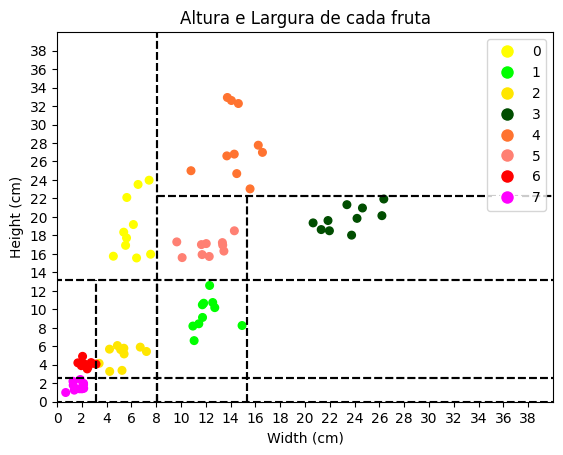

In [275]:
x.show({0: (1,    1,    0),
        1: (0,    1,    0),
        2: (1,  0.9,    0),
        3: (0,  0.3,    0),
        4: (1, 0.45, 0.19),
        5: (1,  0.5, 0.45),
        6: (1,    0,    0),
        7: (1,    0,    1)})